# Stream Averages and Motion Detection

Copyright Luca de Alfaro, 2019-21. 
License: [CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/4.0/).


Prepared on: Mon Sep 20 20:20:30 2021

This is a book chapter; it is not a homework assignment.  
Do not submit it as a solution to a homework assignment; you would receive no credit.


Video lecture 

Suppose you have a series of numbers, and you need to compute their average and standard deviation.  What is a good way for doing this? 
The obvious way is to use the [numpy library](https://www.numpy.org), which offers a wealth of functions to operate on matrices, arrays, and much more. 
Numpy is one of the fundamental packages of Python, and you would be well advised to browse its documentation and familiarize yourself with what it can do. 
With numpy, we can compute average and standard deviation of a list of numbers very simply: 


In [1]:
import numpy as np

s = [1., 2., 3., 3., 2., 4., 3.]
print("avg:", np.average(s))
print("std:", np.std(s))


avg: 2.5714285714285716
std: 0.9035079029052513


## Stream statistics

Assume now that the numbers do not form a fixed length sequence, but rather, a stream of numbers, with new numbers always arriving.  The numbers could represent real-time temperature measurements, or water pressure, or electricity usage, or percentages of utilized CPU cycles, and so forth. 
What do we do in order to compute their average and standard deviation? 

There are various choices, and the way one does it depends on the application. 
It is certainly possible to accummulate all numbers, and then compute their overall average and standard deviation; this allows the computation of statistics that apply to the entire time range for which the data was available. 
More commonly, one is interested in knowing the _recent_ aveage and standard deviation, so that one can compare the most recent data with the average of the last day. 

## Stream Averagerators

One could implement the code that computes the average of a stream in the same portion of code where one reads the stream, as follows:

In [2]:
import random # We use random to simulate a stream.

def read_stream():
    """Reads and returns one number from the stream."""
    return random.random()

def use(x):
    """Code to do something with x"""
    pass

# Here we accummulate the sequence, so we can average it.
seq = []

while True:
    x = read_stream()

    # We add x to the average
    seq.append(x)
    print("avg:", np.average(seq))
    use(x)

    # This is an example, and I don't what the code to run forever.
    if len(seq) == 10:
        break


avg: 0.23922155090603625
avg: 0.5188002585565212
avg: 0.5145488838211322
avg: 0.5043249436146005
avg: 0.49516923108688254
avg: 0.5250618026822309
avg: 0.5867842171351066
avg: 0.5230879616647146
avg: 0.4710949987595934
avg: 0.42537119436226273


However, this approach is horrible in two different ways.  One way is that the implementation is horribly inefficient; our sequence seq will have to hold all the data we read from the stream.  This is bad, and we will fix it later. 

The other way in which this is horrible is that the code to compute the average is intermingled with the code that reads the sequence and passes it to the code that uses it.  It would be much better to separate out the code, for two related reasons. 

**Separation of concerns.** Separating the code makes it easier both to read and to write, because we separate the concerns: when we write the code to compute the average, we can focus on that, disregarding the details of how the stream is read or used; when we write the code that processes the stream, we can focus on that, simply calling a method to compute the average, but disregarding how the average is computed. 
Separating the concerns, or dividing the overall coding task into smaller, independent units, is key.  Each person, at any given time, can keep in mind only a fairly small set of facts; indeed, several studies on software verification point out to the fact that in order to write correct code, programmers usually use no more than a dozen facts about the previous code and input, reflecting what likely is an underlying limitation of our brains.  
By focusing on one task at a time, we can apply our full mental powers to that particular task, making it much easier to write its code. 
The same goes for reading code: it is much easier to understand code that does one specific thing, than code that mixes multiple goals at a time. 

**Ease of modification.** As we mentioned, there are various ways of computing a stream average: there are more and less efficient implementations, and we can consider the entirety of the data read from the stream, or only the most recent one.  It will be easier to change the implementation if the code for computing the stream average is all in the same place, rather than sprinkled in multiple places that must be tracked and updated. 

For these reasons, we introduce _averagerator_ classes that comput  running averages and standard deviations. 
The first we write, _FullAveragerator_, is for computing the statistics of complete sequences.

The class has one method, _add_, used to add data to it, and two properties, _avg_ and _std_, which return the average and standard deviation so far. 



In [3]:
class FullAveragerator(object):

    def __init__(self):
        self.seq = []

    def add(self, x):
        self.seq.append(x)

    @property
    def avg(self):
        return np.average(self.seq)

    @property
    def std(self):
        return np.std(self.seq)


The previous code can be rewritten like this:

In [4]:
averagerator = FullAveragerator()

for _ in range(10):
    x = read_stream()

    # We add x to the average
    averagerator.add(x)
    print("avg:", averagerator.avg)
    use(x)



avg: 0.6927519116725416
avg: 0.842720652550067
avg: 0.5805071325048853
avg: 0.4922120643323337
avg: 0.4493887532549918
avg: 0.5162747325297076
avg: 0.5030848409776513
avg: 0.5120290253314167
avg: 0.5001651732106829
avg: 0.48418106851545917


Much prettier code, isn't it?  The functionality of the averagerator is now nicely encapsulated, making it easy to improve it for the future. 

Let's illustrate how the averagerator works with a picture. 

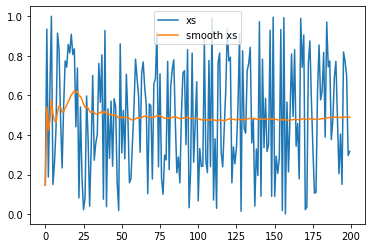

In [5]:
import matplotlib.pyplot as plt

averagerator = FullAveragerator()

xs = []
smooth_xs = []
for _ in range(200):
    x = read_stream()
    xs.append(x)
    averagerator.add(x)
    smooth_xs.append(averagerator.avg)
plt.plot(xs, label="xs")
plt.plot(smooth_xs, label="smooth xs")
plt.legend()
plt.show()


### Efficient Stream Averagerator

The idea in computing a more efficient implementation is to avoid storing the entire sequence, summarizing it instead by aggregate statistics.  The average $E[X]$ of a sequence of $n$ numbers $x_1, x_2, \ldots, x_n$ can be computed as $S_n / n$, where 
$$
S_n = \sum_{i=1}^n x_i \; .
$$
When $x_{n+1}$ arrives, all we need to do is compute 
$S_{n+1} = x_{n+1} + S_n$, and return the average $S_{n+1} / (n+1)$.

Thus, we do not need to store the complete sequence to compute the average: we need to store only the sequence length ($n$ above), and the sequence sum ($S_n$ above). 


In [6]:
class EfficientFullAveragerator(object):

    def __init__(self):
        self.sum_x = 0.
        self.n = 0

    def add(self, x):
        self.sum_x += x
        self.n += 1

    @property
    def avg(self):
        return self.sum_x / self.n


This works, but what about the standard deviation?  

The standard deviation $s$ is the square root of the variance $v$, and for a series $X = x_1, x_2, \ldots, x_n$ of numbers, the variance is 

$$
v = E[(X - E[X])^2] = E[(X - \mu)^2]
$$

where $\mu = E[X]$ is the average. 

We cannot use directly this equation.  The problem is that once we receive $x_1, x_2, \ldots, x_n$, and we want the variance, computing the average $\mu$ is easy: $\mu = S_n / n$.  But to compute the variance, the above formula instructs us to compute $(x_1 - \mu)^2, \ldots, (x_n - \mu)^2$, and this we cannot do without remembering the whole sequence $x_1, \ldots, x_n$. 
So let's try to derive a more helpful formula. 

We can write: 

$$
v = E[(X - \mu)^2] = E[X^2 - 2\mu X + \mu^2] = E[X^2] - 2 \mu E[X] + \mu^2 
= E[X^2] - \mu^2 \; ,
$$

where we have used that $E[X] = \mu$. 
The relation

$$
E[(X - \mu)^2] = E[X^2] - \mu^2 \; ,
$$

_is_ suitable to be computed on the fly. 
It is just the average of the sequence of squares $x_1^2, x_2^2, \ldots$ (and we already know how to compute sequence averages), minus $\mu^2$, which we also already know how to compute.
So, denoting with

$$
Q_n = \sum_{i=1}^n x_i^2 \; , 
$$

we have: 

$$
E[X^2] = Q_n / n
$$ 

and thus:

$$
v = \frac{Q_n}{n} - \mu^2 \; . 
$$

This we can implement.


In [7]:
class EfficientFullAveragerator(object):

    def __init__(self):
        self.sum_x = 0. # S
        self.sum_x_sq = 0. # Q
        self.n = 0

    def add(self, x):
        # We compute the sum of the x, to compute their average.
        self.sum_x += x
        # Sum of the x^2, so we can later compute the average of the x^2.
        self.sum_x_sq += x * x
        self.n += 1

    @property
    def avg(self):
        return self.sum_x / self.n

    @property
    def std(self):
        mu = self.avg # To avoid calling self.avg twice.
        return np.sqrt(self.sum_x_sq / self.n - mu * mu)


Let us play with this implementation.

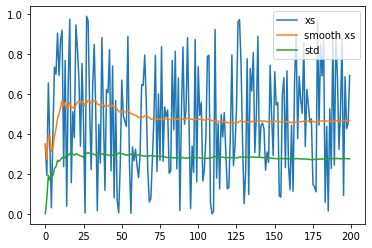

In [8]:
averagerator = EfficientFullAveragerator()

xs = []
smooth_xs = []
stdevs = []
for _ in range(200):
    x = read_stream()
    xs.append(x)
    averagerator.add(x)
    smooth_xs.append(averagerator.avg)
    stdevs.append(averagerator.std)
plt.plot(xs, label="xs")
plt.plot(smooth_xs, label="smooth xs")
plt.plot(stdevs, label="std")
plt.legend()
plt.show()


This works, and we can see that the average tends to $0.5$, and the standard deviation tends to $1/\sqrt{12}$. 
This because the input numbers are uniformy distributed between 0 and 1, and:
$$
\int_0^1 x \: dx = \frac{1}{2} \; , \qquad \int_0^1 \left(x - \frac{1}{2}\right)^2 \: dx = \frac{1}{12} \; .
$$


### Sliding Windows Averagerators

Often, we are more interested in the recent average than in the average since the start of a stream. 
This is especially true if we plan to use the average and standard deviation to identify outliers (possibly incorrect data) in a data stream. 

Consider, for instance, a temperature sensor giving us readings of outside air temperature once per minute. 
If one considers statistics that span more than one year, a location might have an average temperature of 15 (Celsius; all temperatures in the following are in Celsius), and a standard deviation of 15, accommodating Winter temperatures slightly above freezing and Summer ones around 30C. 

Yet, if we saw input data: 
$$
      12.3, 12.3, 12.4, 12.3, 12.4, 12.4, 23.3, 17.5, 12.4, 12.5, 12.6 
$$
we should be suspicious: outside air temperature does not change by more than 10C in a minute. 
We do not know what happened --- someone touched the temperature sensor with a finger, perhaps --- but we know that the data is probably not reflective of air temperature. 


As a concrete example, let us simulate a sensor that senses air temperature.  Air temperature varies between 5C and 25C, as a sine wave (just to make it easy to draw); the sensor has a noise of $\pm 1C$ on each measurement. 

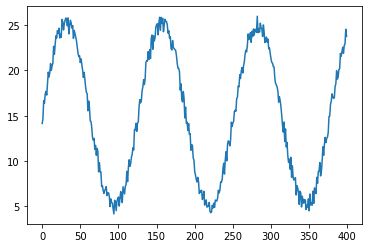

In [9]:
def noisy_temp(noise=1., d=0.05):
    t = -d # time
    while True:
        t += d # We increment time.
        yield 15. + 10. * np.sin(t) + noise * 2.  * (random.random() - 0.5)

# Let's show how this looks.
xs = []
for x in noisy_temp():
    xs.append(x)
    if len(xs) == 400:
        break
plt.plot(xs)
plt.show()



Let us construct a version of this signal with outliers, where once in 50 readings, about, the sensor has an error that can be up to 10C. 

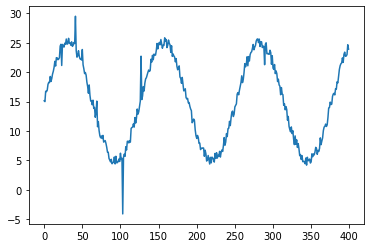

In [10]:
def noisy_temp_with_outliers(noise=1., d=0.05, outlier_prob=0.02, outlier_size=10.):
    t = -d # time
    while True:
        t += d # We increment time.
        x = 15. + 10. * np.sin(t) + noise * 2.  * (random.random() - 0.5)
        # Adds the outlier, with a certain probability.
        if random.random() < outlier_prob:
            x += outlier_size * 2. * (random.random() - 0.5)
        yield x

# Let's show how this looks.
xs = []
for x in noisy_temp_with_outliers():
    xs.append(x)
    if len(xs) == 400:
        break
plt.plot(xs)
plt.show()



Let us compare these outliers, with the average and standard deviation of the whole series. 

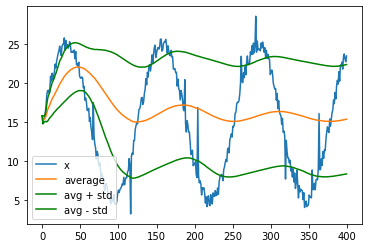

In [11]:
xs = []
avgs = []
stds = []
a = EfficientFullAveragerator()
for x in noisy_temp_with_outliers():
    xs.append(x)
    a.add(x)
    avgs.append(a.avg)
    stds.append(a.std)
    if len(xs) == 400:
        break
plt.plot(xs, label='x')
plt.plot(avgs, label='average')
# Let's move to numpy to compute average plus and minus standard deviation.
a_avg = np.array(avgs)
a_std = np.array(stds)
plt.plot(a_avg + a_std, label='avg + std', color='g')
plt.plot(a_avg - a_std, label='avg - std', color='g')
plt.legend()
plt.show()


As we see: 
* The temperature, even when read without outliers, often differs from the average by more than the overall standard deviation, and this simply due to the daily temperature variations. 
* The outlier themselves, even though quite visible to our eye, often differ from the average by _less_ than the standard deviation, just because the standard deviation is really rather large, as it is influenced not only by sensor noise, but also by the daily temperature cycle. 

To detect these outliers, and change in conditions, it is far more useful to have the average and standard deviation of _recent_ data only, rather than computed over the whole series. 
A _sliding window averagerator_ considers, in the computation of averages and standard deviations, only the most recent $N$ data values, for a specified $N$.

**Exercise:** Complete the code below, defining a sliding window averagerator.  The class should have methods:

* `__init__(self, window_size)` to initialize;
* `add(self, x)`, to add a value

as well as properties `avg` and `std`, as in the previous averagerator classes. 

In [12]:
### Exercise: implement a `SlidingWindowAveragerator`

class SlidingWindowAveragerator(object):

    ### BEGIN SOLUTION
    raise NotImplementedError()
    ### END SOLUTION


In [13]:
### Tests for `SlidingWindowAveragerator`

# First some simple cases.
sa = SlidingWindowAveragerator(20)
for _ in range(10):
    sa.add(10)
    assert sa.avg == 10
    assert sa.std == 0

sa = SlidingWindowAveragerator(10)
for _ in range(10):
    sa.add(4)
assert sa.avg == 4
for _ in range(10):
    sa.add(8)
assert sa.avg == 8
assert sa.std == 0



In [14]:
### Now for slightly more complex tests.

sa = SlidingWindowAveragerator(10)
for i in range(10):
    sa.add(i)
assert sa.avg == 4.5
assert abs(sa.std - 2.87) < 0.1
for i in range(10):
    sa.add(i)
assert sa.avg == 4.5
assert abs(sa.std - 2.87) < 0.1
for _ in range(10):
    sa.add(1)
assert sa.avg == 1
assert sa.std == 0



### Duck Typing

You may wonder: should we have not defined an abstract _Averagerator_ class, and make all these classes, such as _FullAveragaerator_, _EfficientFullAveragerator_, _SlidingWindowAveragerator_, subclasses of the superclass? 

If we were in a strongly typed language, such as Java, the answer would be a resounding Yes.  In Java, a superclass serves as the common type of all objects belonging to the more specialized classes.  One can then define a method accepting a superclass, say, an _Averagerator_, and then pass to it objects of any of its subclasses. 

In Python, objects are rarely tested for the class to which they belong.  The more common pattern in Python is simply the one of calling methods of objects, assuming the methods do the proper thing.  This approach to type checking (or the lack of it) is sometimes called _duck typing:_ [if it quacks like a duck, and it waddles  like a duck](https://www.youtube.com/watch?v=R6kizqah-Po), it is a duck --- meaning, if the object's methods do the right thing, that suffices for us. 

Thus, in Python, except in special cases, the subclass relationship is useful especially if there is non-trivial shared code between a subclass and its superclass.  This not being the case for the Averagerator classes we have defined so far, we have preferred the simpler approach of defining each class individually, which has the advantage of keeping all the class code in the same place.

### Discounting Averagerators

A sliding window abruptly truncates the past: the stream values go from being considered fully considered as part of the average, to being disregarded, in one step. 
A consequence of this is that to implement a sliding window average of size $N$, we actually need to store $N$ values: otherwise, we would not know how to remove a value from the sliding window when the value "falls off" the window. 
Can we do better?  Can we obtain something similar to a sliding window average, but that forgets past values in a smoother way, rather than with an abrupt threshold, and such that the amount of data to remember is independent on window size? 

The answer is Yes.  Given a data stream $x_0, x_1, \ldots, x_n$, the idea is to give to the most recent value $x_n$ a weight of 1, to $x_{n-1}$ a weight of $\alpha$ for $\alpha < 1$, to $x_{n-2}$ weight $\alpha^2$, and so forth: a value that ocurred $k$ "times" ago has weight $\alpha^k$. 
This approach is known as _discounting:_ it is as if the value of the past accumulated experience decreased by a factor of $\alpha$ upon the arrival of a new data value. 

Aside from being a smoother way to average (the effect of past values slowly decays, rather than abruptly dropping out of a fixed size window), discounted averages are also far more efficient to implement. 
The idea, for the average, consists in keeping the running sum of values $S$, and the running sum of weights $W$.  
The average is simply the sum divided by the total weight, or $S/W$. 
When a new value $x$ arrives, $S$ and $W$ are updated by first discounting their current values by $\alpha$, and then adding the contribution of the last value:

$$
  S := \alpha S + x \qquad W := \alpha W + 1 \; .
$$

For the computation of the variance, we proceed in similar fashion.
The implementation is below.


In [15]:
class DiscountedAveragerator:

    def __init__(self, alpha):
        """Creates an averagerator with a specified discounting factor alpha."""
        self.alpha = alpha
        self.w = 0.
        self.sum_x = 0.
        self.sum_x_sq = 0.

    def add(self, x):
        self.w = self.alpha * self.w + 1.
        self.sum_x = self.alpha * self.sum_x + x
        self.sum_x_sq = self.alpha * self.sum_x_sq + x * x

    @property
    def avg(self):
        return self.sum_x / self.w

    @property
    def std(self):
        mu = self.avg
        # The np.maximum is purely for safety.
        return np.sqrt(np.maximum(0., self.sum_x_sq / self.w - mu * mu))


### Data Smoothing

Running averages can be used for smoothing data. 
If you have some background in digital signal theory, a discounted average is a digital filtering operation, whose behavior in the frequency domain can be modeled also with the help of its [_z-transform_](https://en.wikipedia.org/wiki/Z-transform) $1/(1-\alpha/z)$. 
We will be content here with watching it at work. 
Let's build a stream where there is a sinusoidal signal, with superimposed noise.  Here, an iterator comes in handy.

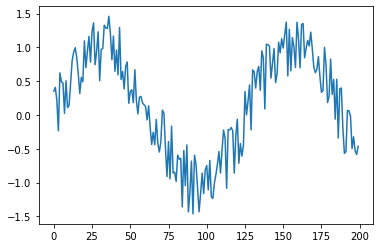

In [16]:
def noisy_sin(noise=1.):
    d = 0.05 # Time increment.
    t = -d # time
    while True:
        t += d # We increment time.
        yield np.sin(t) + noise * (random.random() - 0.5)


# Let's display it.
xs = []
for x in noisy_sin():
    xs.append(x)
    if len(xs) == 200:
        break
import matplotlib.pyplot as plt
plt.plot(xs)
plt.show()


Let's apply now our smoothing average with $\alpha=0.9$, and compare raw and smoothed data.

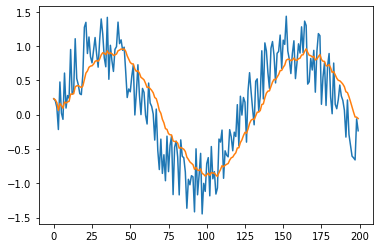

In [17]:
xs = []
smooth_xs = []
a = DiscountedAveragerator(0.9)
for x in noisy_sin():
    xs.append(x)
    a.add(x)
    smooth_xs.append(a.avg)
    if len(xs) == 200:
        break
import matplotlib.pyplot as plt
plt.plot(xs)
plt.plot(smooth_xs)
plt.show()


We see that the output is a smoother, time-delayed, and somewhat contracted (multiplied by a factor smaller than 1) verson of the input.  The time delay and contraction are due to the fact that the average mixes present with past of the sine wave, and would be present even in absence of noise. 

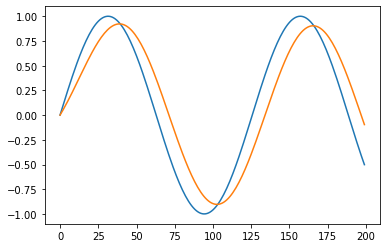

In [18]:
xs = []
smooth_xs = []
a = DiscountedAveragerator(0.9)
for x in noisy_sin(noise=0.):
    xs.append(x)
    a.add(x)
    smooth_xs.append(a.avg)
    if len(xs) == 200:
        break
import matplotlib.pyplot as plt
plt.plot(xs)
plt.plot(smooth_xs)
plt.show()


### Outlier Detection

Let us return to our noisy temperature sensor.  How can we detect the outlier errors? 
One simple idea consists in calling an outlier any point that differs from the average by more than, say, two standard deviations. 
Let us see how this approach would work. 

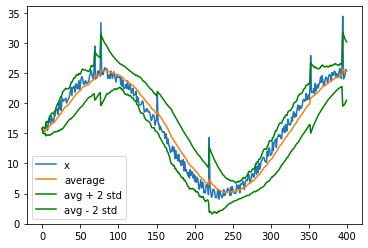

In [19]:
a = DiscountedAveragerator(0.9)

xs = []
avgs = []
stds = []
for x in noisy_temp_with_outliers(d=0.02):
    xs.append(x)
    a.add(x)
    avgs.append(a.avg)
    stds.append(a.std)
    if len(xs) == 400:
        break
plt.plot(xs, label='x')
plt.plot(avgs, label='average')
# Let's move to numpy to compute average plus and minus standard deviation.
a_avg = np.array(avgs)
a_std = np.array(stds)
plt.plot(a_avg + 2. * a_std, label='avg + 2 std', color='g')
plt.plot(a_avg - 2. * a_std, label='avg - 2 std', color='g')
plt.legend()
plt.show()


Indeed, this approach would be able to detect most of the large outliers. We can use this idea to define a cleaned version of the data: when a reading is further away than two standard deviations from the average, we replace the reading with the last valid data.  Let us define a _CleanData_ class that does it for us.

**Exercise:** Use the averagerator to write a class that counts how many spikes there are in the last `n` time units, where `n` is a parameter.

**Exercise:** Complete the following implementation, in which an averagerator is used in order to replace values that are more than num_stds away from the average, with the average itself.

The `CleanData` class is initialized by passing a discount factor for its averagerator.  
Every piece `x` of data is then filtered via a call to `filter(x, num_stdevs)`; this call returns:

*  `x` if the value of `x` is closer than `num_stdevs` standard deviations from the running average,
* the running average if the value of `x` differs from the running average by more than `num_stdevs` standard deviations.

In [20]:
### Exercise: Implement the `CleanData` class

class CleanData(object):

    def __init__(self, discount_factor):
        """
        @param discount_factor: discount factor for the averagerator.
        """
        ### BEGIN SOLUTION
        raise NotImplementedError()
        ### END SOLUTION

    def filter(self, x, num_stdevs=2.):
        """Returns a filtered value for x.
        @param x: the value to be filtered.
        @param num_stdevs: number of standard deviations from the average
           beyond which data is rejected.
        It can be done in 5 lines of code.
        """
        ### BEGIN SOLUTION
        raise NotImplementedError()
        ### END SOLUTION


Let us see how it works, visually:

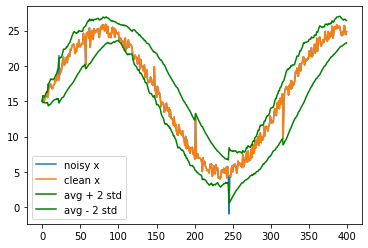

In [21]:
a = DiscountedAveragerator(0.9)
xs = []
clean_xs = []
avgs = []
stds = []
cleaner = CleanData(0.9)
for x in noisy_temp_with_outliers(d=0.02):
    xs.append(x)
    a.add(x)
    avgs.append(a.avg)
    stds.append(a.std)
    clean_xs.append(cleaner.filter(x, num_stdevs=2))
    if len(xs) == 400:
        break
plt.plot(xs, label='noisy x')
plt.plot(clean_xs, label='clean x')
# Let's move to numpy to compute average plus and minus standard deviation.
a_avg = np.array(avgs)
a_std = np.array(stds)
plt.plot(a_avg + 2. * a_std, label='avg + 2 std', color='g')
plt.plot(a_avg - 2. * a_std, label='avg - 2 std', color='g')
plt.legend()
plt.show()


And let us put it through some tests.

In [22]:
### Tests for `CleanData`

a = np.zeros(10)
a[3] = 1
a[8] = 10
c = CleanData(0.9)
aa = [c.filter(x) for x in a]
assert max(aa) < 2.



An alternative idea that seems promising at first thought is to include in the computation of the running average and standard deviation only points that are not outliers.  Let us play with the approach.

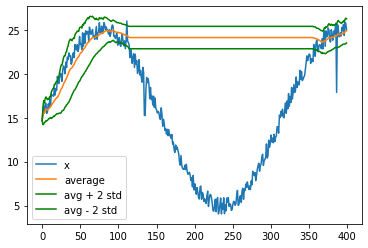

In [23]:
a = DiscountedAveragerator(0.9)

xs = []
avgs = []
stds = []
for x in noisy_temp_with_outliers(d=0.02):
    xs.append(x)
    if len(xs) >= 20:
        # We need enough data to be able to rely on the statistics.
        a_avg, a_std = a.avg, a.std
        x_min, x_max = a_avg - 2 * a_std, a_avg + 2. * a_std
        if x_min < x < x_max:
            # The data is good.
            a.add(x)
    else:
        # We add all data until we have reliable statistics.
        a.add(x)
    avgs.append(a.avg)
    stds.append(a.std)
    if len(xs) == 400:
        break

plt.plot(xs, label='x')
plt.plot(avgs, label='average')
# Let's move to numpy to compute average plus and minus standard deviation.
a_avg = np.array(avgs)
a_std = np.array(stds)
plt.plot(a_avg + 2. * a_std, label='avg + 2 std', color='g')
plt.plot(a_avg - 2. * a_std, label='avg - 2 std', color='g')
plt.legend()
plt.show()


We see that the problem with this approach is that, should the signal change behavior or become more noisy, or drift from its previous range, we risk disregarding all future data.  Better play it safe and include in the statistics all input, in case what we think of as an outlier is really the first in a series of data with higher noise or drift in them.

This is one more case in point supporting the author's motto: _when in doubt, be stupid._ 

It is often better to take a simpler, more robust approach (in this case, averaging all data) than to try to be smart without understanding all the facets of a problem (in this case, trusting our simple outlier detection to the point of letting it screen even the data we feed to it).

## Motion Detection

We can use our averagerators to perform motion detection in a sequence of images captured by a webcam. 
The idea is this.  Each image will be represented as a H x W x 3 3-d array; H and W are the image height and width, respectively, and 3 is the number of color channels of a RGB image. 

We will compute the discounted average and standard deviations of _every single color pixel_ in the image.  If a pixel has a value that is outside the interval $[\mu - k\sigma, \mu + k\sigma]$, where $\mu$ is the pixel average $\sigma$ is the pixel standard deviation, we detect motion. 
Here, $k$ is a sensitivity threshold that specifies how many standard deviations must separate the value of a pixel from its average for us to detect motion. 

Computing mean and standard deviation of every pixel sounds like a crazy idea, until we realize that our DiscountedAveragerator essentially does it for us already.  
So far, we have used the DiscountedAveragerator by passing to it a scalar, that is, a floating point number. 
If we pass to it a value of _x_ which is a Numpy array, everything works: Numpy will re-interpret our $+$, $-$, $*$ operators as operators betwen arrays, and compute mean and standard deviation as _arrays_, one entry per color pixel, rather than scalars. 

### Getting the images

To experiment with motion detection, let us get a series of images captured by a webcam, and convert each image to a numpy matrix.  
We will obtain a list of numpy matrices. 

In [24]:
from PIL import Image
import requests
from zipfile import ZipFile
from io import BytesIO


In [25]:
# Gets the zip file.
ZIP_URL = "https://storage.googleapis.com/lucadealfaro-share/GardenSequence.zip"
r = requests.get(ZIP_URL)
# List of images, represented as numpy arrays.
images_as_arrays = []
# Makes a file object of the result.
with ZipFile(BytesIO(r.content)) as myzip:
    for fn in myzip.namelist():
        with myzip.open(fn) as my_image_file:
            img = Image.open(my_image_file)
            # Converts the image to a numpy matrix, and adds it to the list.
            images_as_arrays.append(np.array(img).astype(np.float32))


Each numpy 3-d array has shape (Y, X, 3), where Y and X are the dimensions of the image (480 x 640 in our case), and 3 correspons to the three color channels.

In [26]:
print(images_as_arrays[0].shape)


(480, 640, 3)


In [27]:
print(images_as_arrays[0][10, 20, 2])


255.0


### Feeding images to the discounted averagerator

Crazy as it might sound, we can feed images to our discounted averagerator.  This is yet another application of [duck typing](https://www.youtube.com/watch?v=R6kizqah-Po): look at the discounted averagerator code again: 

In [28]:
class DiscountedAveragerator:

    def __init__(self, alpha):
        """Creates an averagerator with a specified discounting factor alpha."""
        self.alpha = alpha
        self.w = 0.
        self.sum_x = 0.
        self.sum_x_sq = 0.

    def add(self, x):
        self.w = self.alpha * self.w + 1.
        self.sum_x = self.alpha * self.sum_x + x
        self.sum_x_sq = self.alpha * self.sum_x_sq + x * x

    @property
    def avg(self):
        return self.sum_x / self.w

    @property
    def std(self):
        mu = self.avg
        # The np.maximum is purely for safety.
        return np.sqrt(np.maximum(0., self.sum_x_sq / self.w - mu * mu))


Notice that if we pass an image for x -- a 3D Numpy array -- everything works!  Consider line 12, for instance. 

The first time it is executed, we compute the new `self.sum_x` as the sum of `self.alpha * self.sum_x` plus `x`.  Initially, `self.sum_x` is 0, and `self.alpha * self.sum_x` is also 0, and miraculously for us, 

    0 + x

evaluates to the _3D array_ `x`, because Numpy is kind enough to broadcast (replicate) the `0` and add it to all elements of the array! 

When line 12 is executed again, `self.sum_x` is a 3D array, and `self.alpha * self.sum_x` can again be computed thanks to Numpy's broadcasting `self.alpha` to the 3D array.  The result can then be added to `x`. 

In truth, one still has to take a little bit of care.  Once we feed an `x` of shape (say) (3, 480, 640), we cannot then feed an image of size (3, 1024, 1024) -- the mathematical operations will not work between matrices of different sizes!  So in a more robust implementation, it might be better to reset the running averages if the shape of the image changes.  But this will do for now. 

Let us test it:

First image:


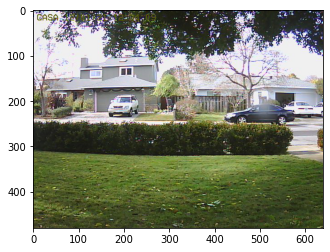

Discounted average of first 10 images:


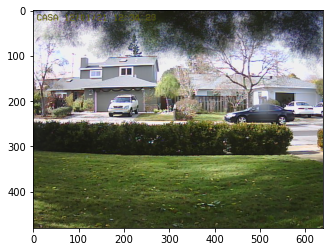

Standard deviation: red


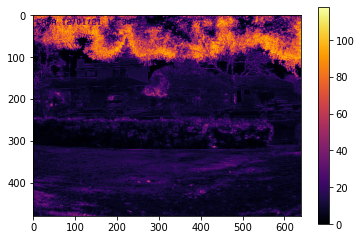

Standard deviation: green


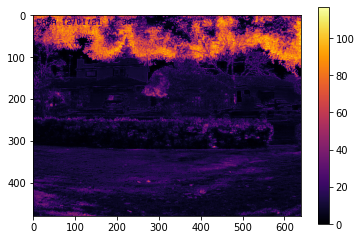

Standard deviation: blue


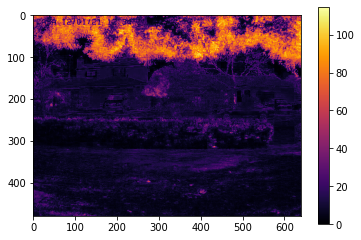

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm

av = DiscountedAveragerator(0.9)
for img in images_as_arrays[:10]:
    av.add(img)

print("First image:")
plt.imshow(images_as_arrays[0] / 255)
plt.show()
print("Discounted average of first 10 images:")
plt.imshow(av.avg / 255)
plt.show()
print("Standard deviation: red")
plt.imshow(av.std[:, :, 0], cmap='inferno')
plt.colorbar()
plt.show()
print("Standard deviation: green")
plt.imshow(av.std[:, :, 1], cmap='inferno')
plt.colorbar()
plt.show()
print("Standard deviation: blue")
plt.imshow(av.std[:, :, 2], cmap='inferno')
plt.colorbar()
plt.show()


### The MotionDetection class

We can use the discounted averagerator to construct  a `MotionDetection` class. 

We will feed images to `MotionDetection`, one by one; the images will be of size $h \times w \times c$, where $h$ is the height, $w$ the width, and $c$ the color depth: in our case, $480 \times 640 \times 3$ (but please, write you class without hardcoding $h$ and $w$). 

As we feed each image, `MotionDetection` computes which pixels of the image have one of the 3 color channels that are outside the $\mu \pm \kappa \sigma$ interval, where $\mu$ is the average, $\sigma$ is the standard deviation, and $\kappa$ is a parameter; we will use $\kappa = 4$ in our experiments, thus detecting motion if values deviate from the average by more than 4 standard deviations.  The result is a $h \times w \times c$ boolean matrix filled with True/False values. 

To perform the above check, you can use a trick: if `a` and `b` are Numpy arrays of the same size, then `a > b` returns an array of the same size, filled with True and False:



In [30]:
a = np.random.random((4, 5, 3))
b = np.random.random((4, 5, 3))
print("a:", a)
print("b:", b)
print("a > b:", a > b)


a: [[[0.17936872 0.43423075 0.34281239]
  [0.19172003 0.0229729  0.97862462]
  [0.08823876 0.58984392 0.97374788]
  [0.10702219 0.22927118 0.12541377]
  [0.43412998 0.1908835  0.80079627]]

 [[0.15991906 0.88486813 0.00918539]
  [0.09529331 0.27573761 0.41955997]
  [0.50826649 0.29524026 0.42989387]
  [0.24708393 0.80277968 0.72034199]
  [0.49565544 0.5976953  0.60224944]]

 [[0.22067539 0.88529565 0.59538123]
  [0.85977059 0.34304772 0.66343021]
  [0.19152839 0.79196956 0.00822193]
  [0.86924384 0.38923409 0.88460699]
  [0.6987431  0.86867293 0.90007854]]

 [[0.97529865 0.99876276 0.63303501]
  [0.66661717 0.19451189 0.21803599]
  [0.24098645 0.36606695 0.69719704]
  [0.29910628 0.14867084 0.13914864]
  [0.06050636 0.21230544 0.17084611]]]
b: [[[2.07336168e-01 4.74602940e-01 2.85059633e-01]
  [7.82669611e-01 7.77544431e-01 1.82544861e-01]
  [4.42203924e-02 8.99970419e-01 9.63260671e-01]
  [3.78410960e-01 1.77257081e-01 3.42190432e-02]
  [8.95059842e-01 7.43844848e-01 1.39645840e-02]]


Moreover, if you have two arrays of the same size, you can compute their _or_ via `np.logical_or`: 

In [31]:
a = np.random.random((4, 5)) > 0.7
b = np.random.random((4, 5)) > 0.7
np.logical_or(a, b)


array([[ True, False,  True, False, False],
       [False,  True,  True, False,  True],
       [False, False,  True,  True,  True],
       [False, False,  True,  True,  True]])

Finally, we take the union of the motion detections over the three color channels, obtaining a boolean 2-d array of size $h \times w$. 
This array will contain the motion detection for each image. 
To take the union, you can use `np.max`, specifying the max to be taken over axis 2, which is the one for color: 


In [32]:
a = np.random.random((4, 5, 3))
aa = a > 0.8
print("aa shape:", aa.shape)
b = np.max(aa, axis=2)
print("b shape:", b.shape)
print("b:", b)


aa shape: (4, 5, 3)
b shape: (4, 5)
b: [[ True False  True False  True]
 [ True False False  True False]
 [ True False  True  True False]
 [False  True  True  True  True]]


We let you build the class `MotionDetection`.

In [33]:
### `MotionDetection` class

class MotionDetection(object):

    def __init__(self, num_sigmas=4., discount=0.96):
        """Motion detection implemented via averagerator.
        @param num_sigmas: by how many standard deviations should a pixel
            differ from the average for motion to be detected.  This is
            the \kappa of the above explanation.
        @param discount: discount factor for the averagerator.
        """
        ### BEGIN SOLUTION
        raise NotImplementedError()
        ### END SOLUTION

    def detect_motion(self, img):
        """Detects motion.
        @param img: an h x w x 3 image.
        @returns: an h x w boolean matrix, indicating where motion occurred.
        A pixel is considered a motion pixel if one of its color bands deviates
        by more than num_sigmas standard deviations from the average."""
        ### BEGIN SOLUTION
        raise NotImplementedError()
        ### END SOLUTION


Let's write a `detect_motion` function to facilitate our experiments.  It will take a list of images, and compute the motion detection of each.  If the motion detection contains more than 500 motion pixels, it puts the detection, and the index of the image, into a list of results. 

In [34]:
def detect_motion(image_list, num_sigmas=4., discount=0.96):
    """Takes as input:
    @param image_list: a list of images, all of the same size.
    @param num_sigmas: a parameter specifying how many standard deviations a
        pixel should be to count as detected motion.
    @param discount: the discount factor for the averagerator.
    """
    detector = MotionDetection(num_sigmas=num_sigmas, discount=discount)
    detected_motion = []
    for i, img in enumerate(image_list):
        motion = detector.detect_motion(img)
        if np.sum(motion) > 500:
            detected_motion.append((i, motion))
    return detected_motion


In [35]:
# Compute the motion detections.
motions = detect_motion(images_as_arrays[:60])


We can finally visualize the detected motions. 

Motion at image 1 : 548 ------------------------------------


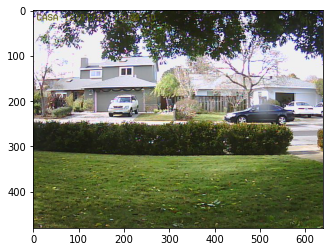

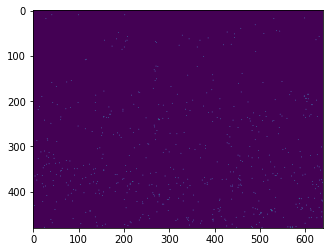

Motion at image 10 : 550 ------------------------------------


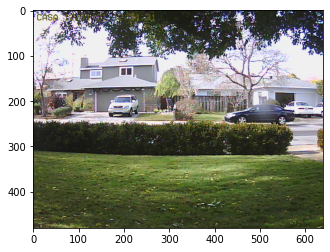

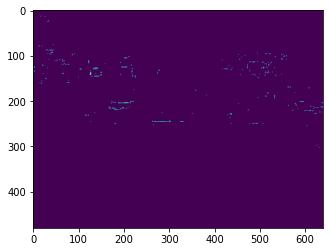

Motion at image 47 : 767 ------------------------------------


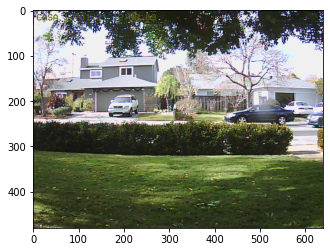

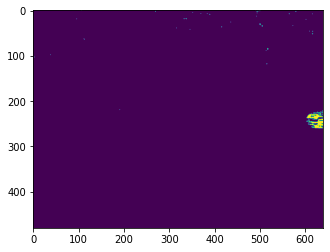

Motion at image 48 : 3288 ------------------------------------


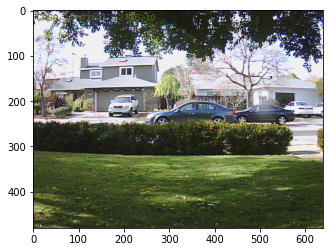

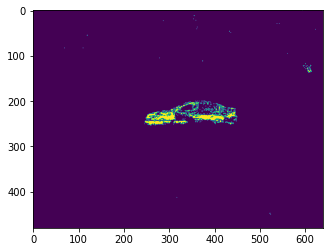

Motion at image 49 : 2043 ------------------------------------


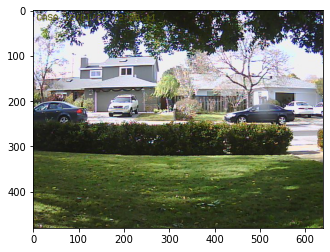

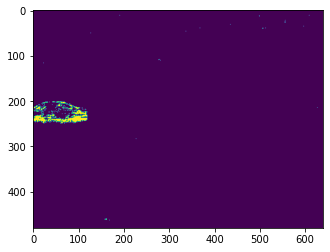

Motion at image 57 : 2651 ------------------------------------


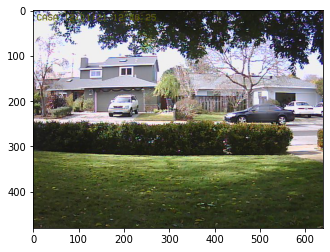

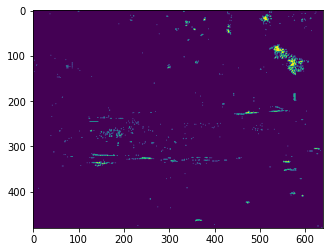

Motion at image 58 : 1199 ------------------------------------


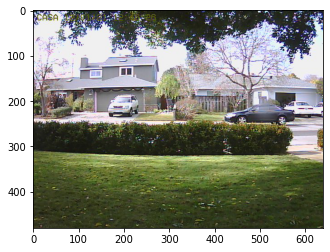

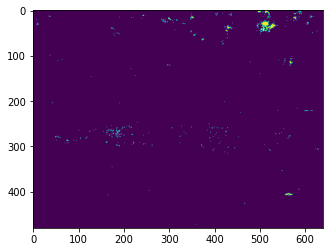

Motion at image 59 : 896 ------------------------------------


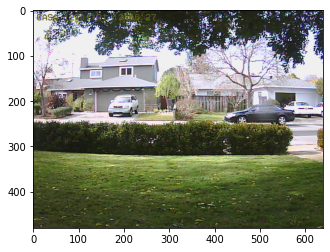

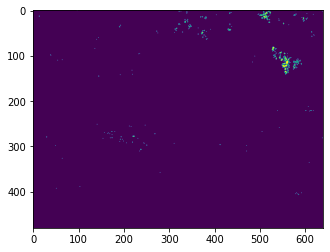

In [36]:
import matplotlib.pyplot as plt
for i, m in motions:
    # We only print images where there are at least 500 pixels of motion.
    if np.sum(m) > 500:
        print("Motion at image", i, ":", np.sum(m), "------------------------------------")
        # We first show the image, for reference.
        plt.imshow(images_as_arrays[i] / 255)
        plt.show()
        # And then the motion detection.
        plt.imshow(m)
        plt.show()


Here are some final tests.



In [37]:
### Tests for motion detection

motions = detect_motion(images_as_arrays[:60])
motion_idxs = [i for i, _ in motions]
assert motion_idxs == [1, 10, 47, 48, 49, 57, 58, 59]
assert np.sum(motions[6][1]) == 1199



We can see that the motion detection does a very reasonable job of detecting the passing cars and bycicle, while almost entirely suppressing the tree that is shaking in the wind.  As the tree shaking is constant, its pixels have very high standard deviation. 
If we plot the standard deviation of each pixel, we get a very good impression of how much noise or regular motion took place at that pixel.

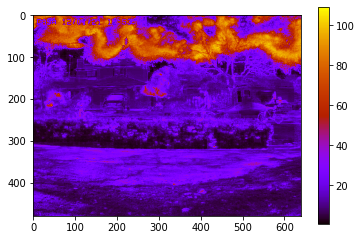

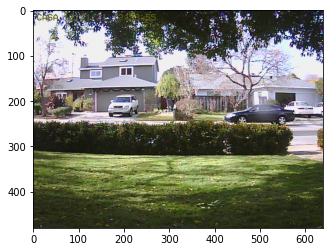

In [38]:
a = DiscountedAveragerator(0.96)
for i, img in enumerate(images_as_arrays):
    a.add(img)
# We display the final sigma.
sigma = np.max(a.std, axis=2)
plt.imshow(sigma, cmap='gnuplot')
plt.colorbar()
plt.show()
# Let's compare with the last image.
plt.imshow(images_as_arrays[-1] / 255)
plt.show()


We see how the constantly-shaking trees give rise by far to the greatest pixel standard deviation.